<a href="https://colab.research.google.com/github/carminesant1/face_detection/blob/main/face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FACE DETECTION**

Il progetto si concentra sullo sviluppo di un sistema di rilevamento facciale

In [ ]:
!git clone https://github.com/carminesant1/face_recognition.git

fatal: destination path 'face_recognition' already exists and is not an empty directory.


---

In una cartella Google Drive è presente una cartella zip che contiene due cartelle:

- p, per le immagini positive (circa 70.000), quindi raffiguranti volti umani;
- n, per le immagini negative (circa 3.000): panorami, animali, oggetti, ecc...

Per l'addestramento del modello, per fini di costo computazionale e bilanciamento del dataset, ho deciso di utilizzare 3.000 immagini per ciascuna categoria

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# Percorso del file ZIP e directory di destinazione
zip_path = '/content/drive/MyDrive/face_recognition(drive)/images.zip'
output_dir = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

Visualizzazione di 10 immagini casuali per cartella

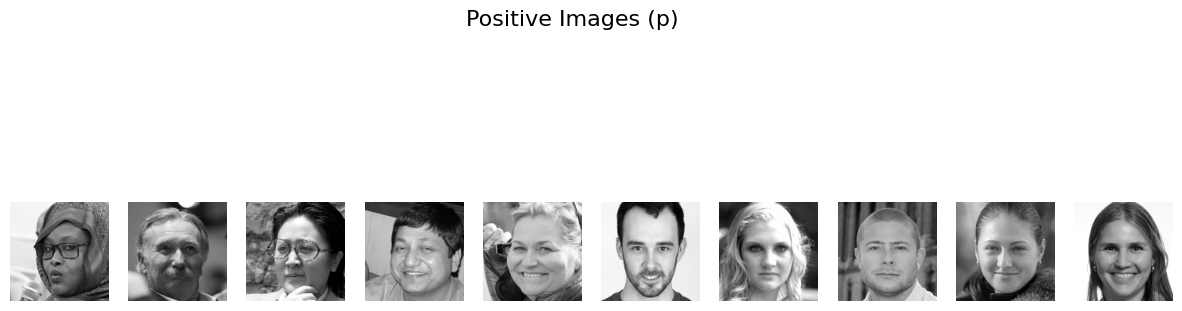

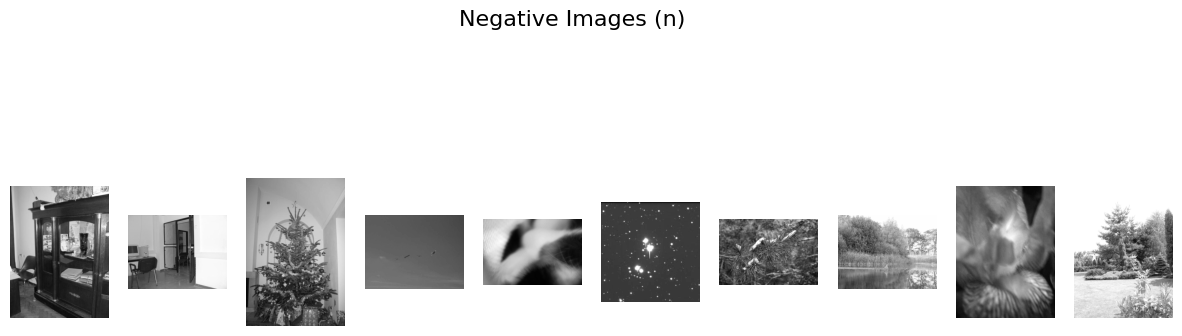

In [ ]:
import cv2
import os
import random
import matplotlib.pyplot as plt

# Percorsi delle cartelle
positive_images_dir = "/content/images/p"
negative_images_dir = "/content/images/n"

# definisco una funzione per estrarre e visualizzare le immagini da una cartella
def load_and_display_images(image_dir, num_images, title):
    # Estrazione di tutti i file nella cartella
    filenames = os.listdir(image_dir)
    random.shuffle(filenames)  # immagini casuali
    selected_files = filenames[:num_images]  # Visualizzaione delle prime num_images immagini

    images = []
    for filename in selected_files:
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # immagini in scala di grigi
        images.append(img)

    # Visualizzo le immagini in una griglia
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)
    for i, ax in enumerate(axs):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
    plt.show()

# Visualizzo 10 immagini positive
load_and_display_images(positive_images_dir, 10, "Positive Images (p)")

# Visualizzo 10 immagini negative
load_and_display_images(negative_images_dir, 10, "Negative Images (n)")


## HOG Feature / Scikit-Learn

Questo progetto implementa un sistema di riconoscimento di volti utilizzando caratteristiche HOG (Histogram of Oriented Gradients) e un classificatore SVM (Support Vector Machine). Il modello è progettato per distinguere tra immagini che contengono volti ("positive") e immagini che non li contengono ("negative"). Il processo include l'estrazione delle caratteristiche HOG, l'addestramento di un modello SVM su un dataset grezzo, successivamente processato ed etichettato, e la valutazione delle prestazioni tramite metriche di accuratezza e report di classificazione.

In [ ]:
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import os
import random

# La funzione extract_hog_features utilizza il metodo HOG per estrarre caratteristiche salienti dalle immagini.
#utili per identificare le strutture e i contorni nei volti.
def extract_hog_features(image):
    features, _ = hog(image,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      block_norm='L2-Hys',
                      visualize=True)
    return features

#La funzione load_dataset carica le immagini positive (con volti) e negative (senza volti) da due cartelle specificate.
#Le immagini vengono preprocessate (ridimensionate a 64x64 pixel) e le caratteristiche HOG vengono calcolate.
#Ogni immagine positiva riceve l'etichetta 1 (volto), mentre ogni immagine negativa riceve l'etichetta 0 (non-volto).
def load_dataset(pos_images_dir, neg_images_dir, num_samples=3000):
    data = []
    labels = []

    # Carica immagini positive (volti)
    pos_filenames = os.listdir(pos_images_dir)
    random.shuffle(pos_filenames)  # Randomizzo la posizione delle immagini
    pos_filenames = pos_filenames[:num_samples]  # Prendo num_samples immagini casuali

    # Carica immagini negative (non-volti)
    neg_filenames = os.listdir(neg_images_dir)
    random.shuffle(neg_filenames)  # Randomizzo la posizione delle immagini
    neg_filenames = neg_filenames[:num_samples]  # Prendo num_samples immagini casuali



#ciascuna immagine della cartella viene letta, trasformata in scala di grigi, ridimensionata
#successivamente vengono calcolate le HOG feature
#label 1 per immagini positive(volti), 0 altrimenti
#le feature e le label vengono converite in array numpy
    for filename in pos_filenames:
        img_path = os.path.join(pos_images_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))
        img = cv2.GaussianBlur(img, (5, 5), 0)  # Applico Gaussian Blur per ridurre il rumore e levigare i dettagli dell'immagine
        img = cv2.equalizeHist(img)  # Applico Equalizzazione Istogramma, per migliorare il contrasto di un'immagine in scala di grigi
        hog_features = extract_hog_features(img)
        data.append(hog_features)
        labels.append(1)

    # Carica immagini negative (non-volti)
    for filename in neg_filenames:
        img_path = os.path.join(neg_images_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))
        img = cv2.GaussianBlur(img, (5, 5), 0)  # Applico Gaussian Blur per ridurre il rumore e levigare i dettagli dell'immagine
        img = cv2.equalizeHist(img)  # Applico Equalizzazione Istogramma, per migliorare il contrasto di un'immagine in scala di grigi
        hog_features = extract_hog_features(img)
        data.append(hog_features)
        labels.append(0)
    return np.array(data), np.array(labels)

# percorso delle immagini positive e negative, una volta scaricate dal Drive
negative_images = "/content/images/n"
positive_images = "/content/images/p"

# Carico il dataset con la funzione sopra dichiarata
X, y = load_dataset(positive_images, negative_images)

# Divido in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Addestro il modello SVM con kernel "rbf" per tracciare la non-linearità delle feature
svm = SVC(kernel='rbf', probability=True, random_state=42)  # Puoi usare kernel='rbf' per un kernel non lineare
svm.fit(X_train, y_train)

# previsioni
y_pred = svm.predict(X_test)

# valutazione del modello sul test set
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9977777777777778
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       879
           1       1.00      1.00      1.00       921

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



In [ ]:
import cv2
import numpy as np

# Funzione per applicare sliding window: genera finestre rettangolari
def sliding_window(image, step_size, window_size):
    """
    Genera finestre scorrevoli su un'immagine.
    :param image: immagine input.
    :param step_size: passo di scorrimento (in pixel).
    :param window_size: dimensione della finestra (larghezza, altezza).
    :return: coordinate (x, y) e il contenuto della finestra corrente.
    """
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

# Funzione per calcolare l'Intersection over Union (IoU)
def calculate_iou(box1, box2):
    """
    Calcola l'Intersection over Union (IoU) tra due bounding box.
    :param box1: prima bounding box (x1, y1, x2, y2).
    :param box2: seconda bounding box (x1, y1, x2, y2).
    :return: valore IoU tra 0 e 1.
    """
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Calcola area di intersezione
    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)

    # Calcola area delle due box
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calcola l'unione
    union_area = box1_area + box2_area - inter_area

    # Evita divisione per zero
    if union_area == 0:
        return 0

    return inter_area / union_area

# Funzione per Non-Maximum Suppression
def non_max_suppression(bounding_boxes, iou_threshold=0.5):
    """
    Applica Non-Maximum Suppression per filtrare le bounding box.
    :param bounding_boxes: lista di bounding box.
    :param iou_threshold: soglia di IoU per il filtraggio.
    :return: lista di bounding box finali.
    """
    if len(bounding_boxes) == 0:
        return []

    # Ordina le box in base all'area decrescente
    bounding_boxes = sorted(bounding_boxes, key=lambda box: (box[2] - box[0]) * (box[3] - box[1]), reverse=True)

    final_boxes = []
    while bounding_boxes:
        # Prendi la box con area maggiore
        current_box = bounding_boxes.pop(0)
        final_boxes.append(current_box)

        # Filtra le box che hanno IoU maggiore della soglia
        bounding_boxes = [
            box for box in bounding_boxes
            if calculate_iou(current_box, box) < iou_threshold
        ]

    return final_boxes

# Funzione per rilevare volti
def detect_faces(image, model, window_size=(128, 128), step_size=16):
    """
    Rileva volti in un'immagine utilizzando sliding window e un modello predittivo.
    :param image: immagine input.
    :param model: modello predittivo.
    :param window_size: dimensione delle finestre.
    :param step_size: passo di scorrimento.
    :return: lista di bounding box candidate.
    """
    bounding_boxes = []

    # Pre-elaborazione dell'immagine
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray = cv2.GaussianBlur(image_gray, (5, 5), 0)  # Applico Gaussian Blur per ridurre il rumore e levigare i dettagli dell'immagine
    image_gray = cv2.equalizeHist(image_gray)  # Applico Equalizzazione Istogramma, per migliorare il contrasto di un'immagine in scala di grigi

    for (x, y, window) in sliding_window(image_gray, step_size, window_size):
        if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
            continue

        # Estrai caratteristiche HOG
        features = extract_hog_features(window)
        features = features.reshape(1, -1)

        # Predizione
        prediction = model.predict(features)

        # Se è un volto, salva le coordinate della bounding box
        if prediction == 1:
            bounding_boxes.append((x, y, x + window_size[0], y + window_size[1]))

    return bounding_boxes

# Carica una nuova immagine
image_path = "/content/face_recognition/Chuck.jpg"
image = cv2.imread(image_path)

# Rileva volti
bounding_boxes = detect_faces(image, svm, window_size=(128, 128), step_size=16)

# Applica Non-Maximum Suppression
final_boxes = non_max_suppression(bounding_boxes, iou_threshold=0.5)

# Disegna le bounding box sull'immagine originale
for (x1, y1, x2, y2) in final_boxes:
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

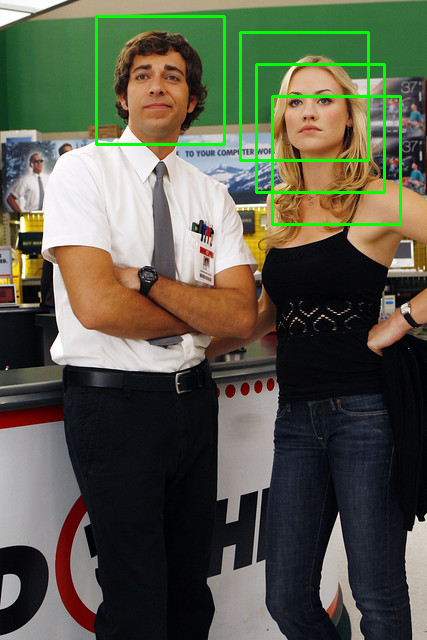

In [ ]:
from google.colab.patches import cv2_imshow
# Mostra l'immagine con le bounding box
cv2_imshow(image)

Da come si evince dall'immagine di prova, il modello ha riconosciuto i volti ma, per il volto femminile, ha restituito box multiple

## Haar Feature / OpenCV

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow
from google.colab import files
from sklearn.pipeline import Pipeline

Compilazione della versione 3.4 di OpenCV dalla repository su GitHub

In [ ]:
!apt-get update
!apt-get install -y build-essential cmake git libgtk2.0-dev pkg-config libavcodec-dev libavformat-dev libswscale-dev
!git clone --branch 3.4 https://github.com/opencv/opencv.git
!git clone --branch 3.4 https://github.com/opencv/opencv_contrib.git

!mkdir -p /content/opencv_build
%cd /content/opencv_build

!cmake -D CMAKE_BUILD_TYPE=Release \
        -D CMAKE_INSTALL_PREFIX=/usr/local \
        -D OPENCV_EXTRA_MODULES_PATH=/content/opencv_contrib/modules \
        -D BUILD_EXAMPLES=ON \
        /content/opencv

!make -j8
!make install
!ldconfig


Output streaming troncato alle ultime 5000 righe.
Get:26 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:27 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 gir1.2-gtk-2.0 amd64 2.24.33-2ubuntu2.1 [210 kB]
Get:28 http://archive.ubuntu.com/ubuntu jammy/main amd64 libarchive-cpio-perl all 0.10-1.1 [9,928 B]
Get:29 http://archive.ubuntu.com/ubuntu jammy/main amd64 libffi-dev amd64 3.4.2-4 [63.7 kB]
Get:30 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libglib2.0-dev-bin amd64 2.72.4-0ubuntu2.4 [117 kB]
Get:31 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libblkid-dev amd64 2.37.2-4ubuntu3.4 [185 kB]
Get:32 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsepol-dev amd64 3.3-1build1 [378 kB]
Get:33 http://archive.ubuntu.com/ubuntu jammy/main amd64 libselinux1-dev amd64 3.3-1build2 [158 kB]
Get:34 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libmount-dev amd64 2.37.2-4ubuntu3.4

Generazione del file txt contenente il percorso per ciascuna immagine positiva

In [ ]:
!find /content/images/p -type f -iname "*.png" > /content/positives.txt

Aggiunta delle coordinate della box al file delle immagini positive

In [ ]:
# Percorso della directory delle immagini positive
positives_dir = "/content/images/p"
positives_file = "positives.txt"

# Generazione del file positives.txt con bounding box fisse
with open(positives_file, "w") as f:
    for root, _, files in os.walk(positives_dir):
        for file in files:
            if file.endswith(".png"):
                file_path = os.path.join(root, file)
                f.write(f"{file_path} 1 0 0 128 128\n")

positives.txt generato con bounding box fisse (0 0 128 128)!


File txt per le immagini negative

In [ ]:
!find /content/images/n -type f -iname "*.jpg" > /content/negatives.txt

Generazione del filw positive.vec, ridimensionamento delle immagini a 24x24

In [ ]:
!/usr/local/bin/opencv_createsamples -info positives.txt -vec /content/positives.vec -w 24 -h 24 -num 70000


Info file name: positives.txt
Img file name: (NULL)
Vec file name: /content/positives.vec
BG  file name: (NULL)
Num: 70000
BG color: 0
BG threshold: 80
Invert: FALSE
Max intensity deviation: 40
Max x angle: 1.1
Max y angle: 1.1
Max z angle: 0.5
Show samples: FALSE
Width: 24
Height: 24
Max Scale: -1
RNG Seed: 12345
Create training samples from images collection...
Done. Created 70000 samples


In [ ]:
mkdir /content/classifier/

Training del modello Haar Cascade

In [ ]:
!/usr/local/bin/opencv_traincascade -data /content/classifier -vec /content/positives.vec -bg /content/negatives.txt -numPos 3500 -numNeg 3000 -numStages 15 -w 24 -h 24 -featureType HAAR

PARAMETERS:
cascadeDirName: /content/classifier
vecFileName: /content/positives.vec
bgFileName: /content/negatives.txt
numPos: 3500
numNeg: 3000
numStages: 15
precalcValBufSize[Mb] : 1024
precalcIdxBufSize[Mb] : 1024
acceptanceRatioBreakValue : -1
stageType: BOOST
featureType: HAAR
sampleWidth: 24
sampleHeight: 24
boostType: GAB
minHitRate: 0.995
maxFalseAlarmRate: 0.5
weightTrimRate: 0.95
maxDepth: 1
maxWeakCount: 100
mode: BASIC
Number of unique features given windowSize [24,24] : 162336

===== TRAINING 0-stage =====
<BEGIN
POS count : consumed   3500 : 3500
NEG count : acceptanceRatio    3000 : 1
Precalculation time: 67
+----+---------+---------+
|  N |    HR   |    FA   |
+----+---------+---------+
|   1|        1|        1|
+----+---------+---------+
|   2|    0.998|    0.298|
+----+---------+---------+
END>
Training until now has taken 0 days 0 hours 4 minutes 30 seconds.

===== TRAINING 1-stage =====
<BEGIN
POS count : consumed   3500 : 3507
NEG count : acceptanceRatio    3000 :

Download dei parametri del modello allenato

In [ ]:
file_path = '/content/classifier/cascade.xml'

files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Caricamento del modello dalla repository GitHub

In [ ]:
!git clone https://github.com/carminesant1/face_recognition.git

Cloning into 'face_recognition'...
remote: Enumerating objects: 2043, done.
remote: Counting objects: 100% (2043/2043), done.
remote: Compressing objects: 100% (2040/2040), done.
remote: Total 2043 (delta 52), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (2043/2043), 83.66 MiB | 27.33 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [ ]:
cascade_path = '/content/face_recognition/cascade.xml'

haar_cascade = cv2.CascadeClassifier(cascade_path)

Prova su un'immagine con due volti

Immagine: 


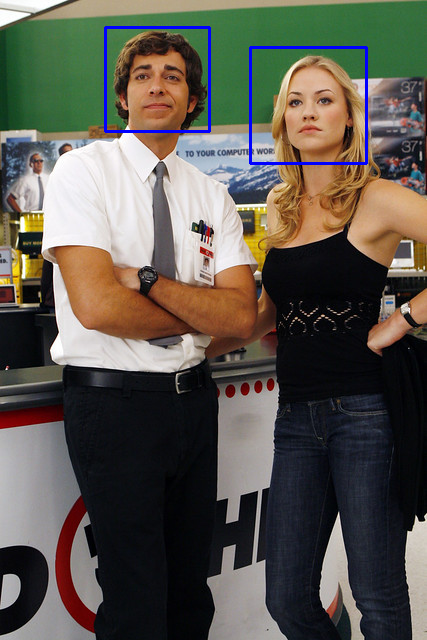

In [ ]:
pos_image = cv2.imread('/content/face_recognition/Chuck.jpg')

# Converto l' immagine in scala di grigi
pos_gray = cv2.cvtColor(pos_image, cv2.COLOR_BGR2GRAY)

# Uso il modello Haar Cascade per rilevare oggetti
'''
scaleFactor determina il rapporto con cui l'immagine viene ridimensionata a ogni passaggio
minNeighbors indica il numero minimo di "rettangoli vicini" richiesti per confermare una rilevazione
'''
pos_objects = haar_cascade.detectMultiScale(pos_gray, scaleFactor=1.1, minNeighbors=7, minSize=(24, 24))

# Disegno i rettangoli attorno agli oggetti rilevati
for (x, y, w, h) in pos_objects:
    cv2.rectangle(pos_image, (x, y), (x+w, y+h), (255, 0, 0), 2)

# Visualizzo i risultati
print("Immagine: ")
cv2_imshow(pos_image)



# **PROGRAMMA**

In [ ]:
#url immagine
url_img = input("Inserisci l'URL o il percorso dell'immagine: ")

# Pipeline
pipeline_steps = [
    ("read_image", lambda x: cv2.imread(x)),
    ("convert_to_gray", lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)),
    ("detect_faces", lambda gray_img: haar_cascade.detectMultiScale(
        gray_img, scaleFactor=1.1, minNeighbors=7, minSize=(24, 24)
    ))
]

# Esecuzione manuale della pipeline
try:
    data = url_img
    for step_name, step_func in pipeline_steps:
        data = step_func(data)

    # Risultato finale: coordinate dei volti
    print(f'Rilevati {len(data)} volti:')
    print(data)
except Exception as e:
    print(f"Errore: {e}")

Inserisci l'URL o il percorso dell'immagine: /content/face_recognition/Chuck.jpg
Rilevati 2 volti:
[[105  27 104 104]
 [250  47 116 116]]
